<h1><center> They say it's risky, should I go?</center></h1>
![avalanche](../img/avalanche2.gif)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import folium
import branca
import json
import math 

##### Data loading:
We load fatal avalanche accidents datasets of the past 15 years.

In [2]:
df_accidents = pd.read_excel('../data/accidents/df_accidents_final.xlsx')

###  Off-piste skiing or Backcountry touring ?

For which activity do we see most of the accidents ?

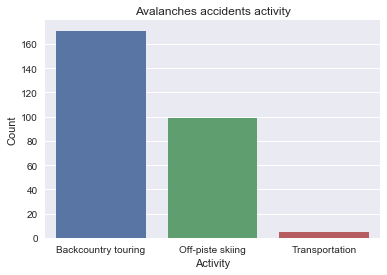

In [8]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

More accidents are related to backcountry touring activity. But from this result, we can not conclude which activity is safer.

Moreover, in which conditions do the skiiers go on a ride, depending on their activity ?
<br>
Is there a class of persons that is more educated on avalanche risks ?

In order to limit avalanche risk, it is important to be aware of the destructive power of avalanches, understand when and why they happen (snow and meteorological conditions). 
One of the main factor allowing to avoid accidents is increasing the awareness of the risks. And this begins with consulting the avalanche danger level before going on a ride.

Thus, it could be interesting to study skiiers' behaviour, and see if, depending on the activity (backcountry or off-piste), one group has a tendancy to be more risky considering avalanche danger levels. 
To answer this question, we decided to count the number of accidents per danger level, considering two groups: people doing backcountry touring and people doing off-piste skiing.

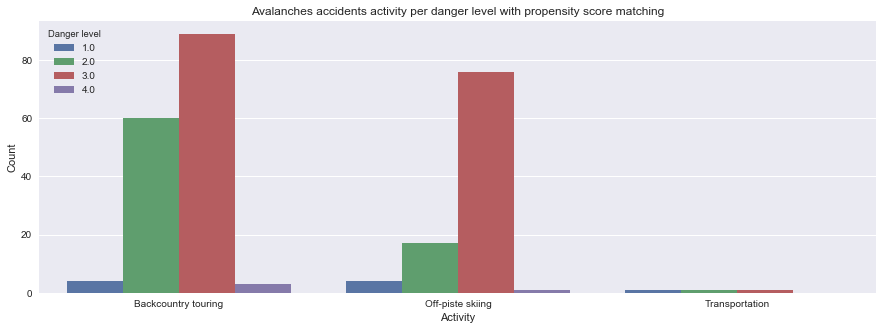

In [10]:
fig, ax = plt.subplots(1, sharey=True, figsize=(15,5));

g = sns.countplot(x="Activity", hue = 'Danger level', data=df_accidents, ax = ax);
ax.set_title('Avalanches accidents activity per danger level with propensity score matching');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

From this result, we see that backcountry related accidents have a mean danger level lower than off-piste related accidents. Thus it seems that people doing off-piste skiing have a tendancy to be more risky considering avalanche danger levels.
But to be more accurate and give more weight to this statement, it could be interesting to balance the dataset in order to match each data point from the backcountry group with exactly one data point from the off-piste group.
Only danger levels 2 and 3 are taken into account in this analysis, as the other danger levels can be considered as outliers.

##### Propensity score matching:

Our hypothesis states that the behaviour of skiiers may depend on the activity they are doing.

But to draw valid conclusions, a propensity score matching is done. Propensity score purpose is to balance the dataset across treatment groups.
<br>
Propensity scores are used to match each data point from the treated group with exactly one data point from the control group. The matching allows to maximize the similarity between matched subjects, by balancing feature-value distributions between the two groups. 
<br> For example, comparing accidents data between one group gathering 6 backcountry accidents that caught 8 people at the end of the season with another group gathering 90 off-piste accidents that caught 150 people is not very relevant, due to the group's size difference and the non similarity between features such as elevation, aspect, month. 

<br>
In our case, the features taken into account for the matching are the aspect, the elevation, the month and the number of people caught in the avalanche.

In [48]:
from sklearn import linear_model 
# Groups: activity --> backcountry and hors piste

# Keep only 2 activities we want to compare
df = df_accidents[df_accidents.Activity != 'Transportation']
df = df[df.Activity != 'Building']

df = df[df['Danger level'].apply(lambda d: d in [2,3])] # Keep only danger levels 2 and 3
df['month'] = df.date.apply(lambda d: d.month)
df = df.set_index(['date','Longitude','Latitude'])

# Create dic of aspect to get numerical values from aspect categories
aspect_cos = {}
aspect_sin = {}
for val, aspect in enumerate(order):
    aspect_cos[aspect]=math.cos(val*(math.pi/8))
    aspect_sin[aspect]=math.sin(val*(math.pi/8))

df['cos_aspect'] = df.Aspect.replace(aspect_cos)
df['sin_aspect'] = df.Aspect.replace(aspect_sin)

In [49]:
# Create feature matrix
features = df[['Activity','cos_aspect','sin_aspect','Elevation','month','caught','Danger level']]
features['Activity'] = features['Activity'].apply(lambda x: 1 if x == 'Backcountry touring' else 0)
features = features.dropna()

# Create data matrix
data = features
features = features.drop(['Danger level','Activity'], axis = 1)

Use logistic regression to estimate propensity scores for all points in the dataset.

In [50]:
model = linear_model.LogisticRegression()
model.fit(features, data.Activity)
pred = model.predict(features)

accuracy = sum(pred == data.Activity) / len(data.Activity)
print('accuracy: ', accuracy)

accuracy:  0.605809128631


The propensity scores are calculated and added to the dataframe

In [51]:
# Get propensity score
pscore = model.predict_proba(features)
data = data.assign(propensity_score = pscore[:,0])
data.head(3)

,,,Activity,cos_aspect,sin_aspect,Elevation,month,caught,Danger level,propensity_score
date,Longitude,Latitude,,,,,,,,
2002-01-02,7.528077,46.546476,1,9.238795e-01,-0.382683,2360,1,1,3.0,0.502397
2002-01-03,9.815028,46.855337,0,-1.836970e-16,-1.000000,2400,1,1,3.0,0.393845
2002-01-13,9.830075,46.836754,0,6.123234e-17,1.000000,2240,1,1,2.0,0.467169


The propensity scores are used to match each data point from the backcountry skiing group with exactly one data point from the off-piste skiing group. To do that, we decided to use networkx package and work with DiGraph, which corresponds to directed graph with self loops.

In [52]:
import networkx as nx

G = nx.DiGraph()

# add a node for each sample
for i, row in data.iterrows():
    G.add_node(row.name, propensity=row['propensity_score'], Activity=row['Activity'])

# add an edge between treated control with propensity diff as weight
for n1, att1 in G.nodes(data=True):
    for n2, att2 in G.nodes(data=True):
        if att1['Activity'] == 1 and att2['Activity'] == 0:
            diff = abs(att1['propensity'] - att2['propensity'])
            G.add_edge(n1, n2, weight=1-diff)

matchings = nx.max_weight_matching(G)

Doublons are found for the matching.
So we split the matching output to get only unique matches (93 in total, as it should).

In [53]:
matchings
true_matching = {}

for treat,no_treat in matchings.items():
    if treat not in true_matching.values():
        true_matching[treat] = no_treat

The new matching is applied to our dataset.

In [54]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_offpiste = data.loc[[off_piste for backcountry, off_piste in true_matching.items()]]

# Assign propensity score matching to the dataframe to keep only matched datapoints
data_backcountry = data.loc[[backcountry for backcountry, off_piste in true_matching.items()]]

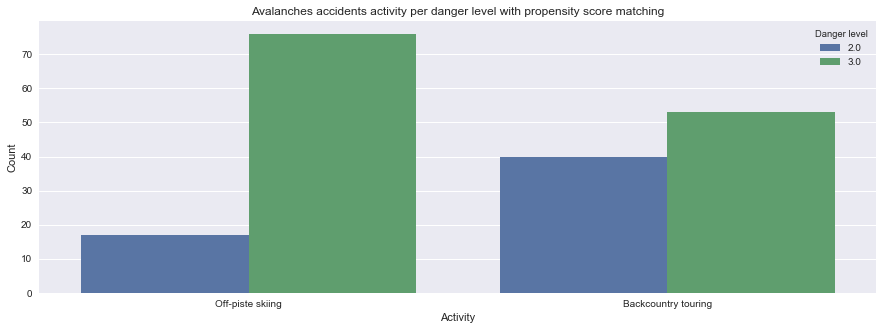

In [55]:
data_new = pd.concat([data_offpiste,data_backcountry])
fig, ax = plt.subplots(1, sharey=True, figsize=(15,5));

g = sns.countplot(x="Activity", hue = 'Danger level', data=data_new, ax = ax);
g.set(xticklabels=['Off-piste skiing','Backcountry touring'])
ax.set_title('Avalanches accidents activity per danger level with propensity score matching');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

From our results, accidents due to backcountry activity show in general reduced danger levels compared to accidents caused by off-piste skiing. This could suggest a difference of behaviour between both groups. Indeed, this result could be explained by the fact that people doing backcountry touring have a better knowledge and awareness of the risks than people doing off-piste skiing.

It could also be interesting to confirm our hypothesis by applying a statistical test.
Thus, we investigate the mean difference of avalanche danger levels between the two groups, which are off-piste skiing group and backcountry touring group.
To do that, we decided to perform an independant 2 sample t-test to test if, wether or not, the difference in danger level is significant between the groups. So our hypothesis are:
- Ho: There is no difference between the two means
- Ha: There is a difference between the two means

In [56]:
# Student t-test
from scipy import stats
t, p = stats.ttest_ind(data_offpiste['Danger level'], data_backcountry['Danger level'])

if p<0.05:
    print( 'p = %f --> The independant 2 sample student t-test rejects the null Hypothesis' %p)

p = 0.002371 --> The independant 2 sample student t-test rejects the null Hypothesis


The student t-test gives a p-value lower than 0.05, and confirms our first assumption.
A propensity score matching was asessed to balance the dataset in order to draw proper conclusions.
Thus, a preventive behaviour may allow to reduce the avalanche risk.